# Classifing Movie Reviews as Positive or Negative.

Import the necessary libaries

In [3]:
pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.4 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [5]:
from google.colab import drive
import os

drive.mount('/content/drive')
directory=os.getcwd()+'/drive/MyDrive/Deep Learning'

Mounted at /content/drive


In [6]:
dataset = directory+'/IMDB Dataset.csv'

Import the dataset

In [7]:
import pandas as pd

df = pd.read_csv(dataset)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Explanatory Data Analysis

In [8]:
df.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  This show comes up with interesting locations ...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

In [9]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [10]:
df['review_sentiment']=df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.sample(5)

,review,sentiment,review_sentiment
28881,a really awful movie about a 30 meters long sh...,negative,0
28735,"Well, because I'm a musician I thought, maybe ...",negative,0
13806,shakespeare's plays have a way of transcending...,positive,1
34403,I would have to say this is a great movie. <br...,positive,1
39009,"""Someones at the Door"". OHHH, How I miss this ...",positive,1


Split the data into training and testing data

In [11]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(df['review'],df['sentiment'], stratify=df['negative'])
X_train, X_test, y_train, y_test = train_test_split(df['review'],df['review_sentiment'], test_size=0.2)

In [12]:
X_train.head(4)

22097    This film was amazing. It is an inspiring piec...
428      I never fell asleep during a movie. Never. Thi...
25515    At first glance, it would seem natural to comp...
15427    Okay. Look- I've seen LOTS and I do mean LOTS ...
Name: review, dtype: object

Import BERT preprocessor and BERT model

In [13]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Build the model

In [14]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [16]:
len(X_train)

40000

In [17]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train the model

In [18]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 448s 347ms/step - loss: 0.6082 - accuracy: 0.6688 - precision: 0.6725 - recall: 0.6575
Epoch 2/10
1250/1250 [==============================] - 434s 348ms/step - loss: 0.5446 - accuracy: 0.7286 - precision: 0.7331 - recall: 0.7186
Epoch 3/10
1250/1250 [==============================] - 434s 347ms/step - loss: 0.5300 - accuracy: 0.7385 - precision: 0.7442 - recall: 0.7262
Epoch 4/10
1250/1250 [==============================] - 434s 347ms/step - loss: 0.5195 - accuracy: 0.7435 - precision: 0.7486 - recall: 0.7329
Epoch 5/10
1250/1250 [==============================] - 435s 348ms/step - loss: 0.5160 - accuracy: 0.7452 - precision: 0.7489 - recall: 0.7373
Epoch 6/10
1250/1250 [==============================] - 435s 348ms/step - loss: 0.5120 - accuracy: 0.7481 - precision: 0.7518 - recall: 0.7405
Epoch 7/10
1250/1250 [==============================] - 434s 347ms/step - loss: 0.5114 - accuracy: 0.7488 - precision: 0.7542 - recall: 0.7378

Evaluate the model

In [19]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 109s 344ms/step - loss: 0.4771 - accuracy: 0.7808 - precision: 0.7714 - recall: 0.7994


[0.4771312475204468,
 0.7807999849319458,
 0.7714230418205261,
 0.7994412183761597]

In [20]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

313/313 [==============================] - 107s 341ms/step


In [21]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, ..., 0, 1, 0])

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[3802, 1187],
       [1005, 4006]])

Text(50.722222222222214, 0.5, 'Truth')

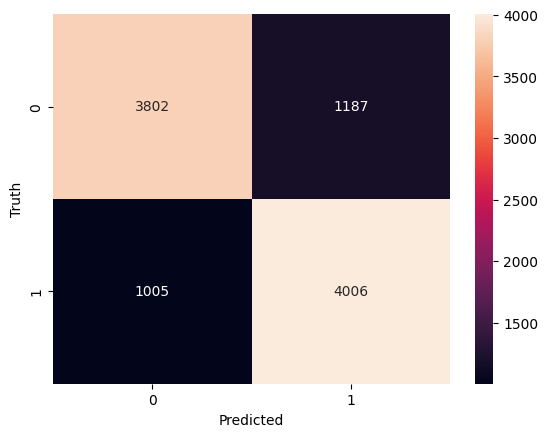

In [23]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [24]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78      4989
           1       0.77      0.80      0.79      5011

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



Inference

In [25]:
reviews = [
    'This movie was a complete letdown. The plot was confusing, the characters were one-dimensional, and the climax felt forced. I expected much more from the hype surrounding it.',
    'I was a big fan of the original, but this sequel failed to capture the magic. The storyline felt recycled, and the new characters lacked depth. Its sad to see a once-promising franchise go down this path.',
    'This film is a heartwarming tale that beautifully captures the essence of human emotions. The characters are relatable, and the storyline is both touching and inspiring. I left the theater with a smile on my face.',
    'This movie is nothing short of an incredible cinematic experience. The direction, cinematography, and music blend seamlessly to create a masterpiece. Every frame felt meticulously crafted, and the emotional depth of the characters stayed with me long after the credits rolled.',
]
model.predict(reviews)

1/1 [==============================] - 1s 749ms/step


array([[0.28683048],
       [0.5742603 ],
       [0.7740727 ],
       [0.9714702 ]], dtype=float32)